## load package

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install torchinfo
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-4r20jcac
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-4r20jcac
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e7cbea0bbd546167b9d1757b2cfeca3fbe26a33e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.0 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.2-py

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torchinfo
import segmentation_models_pytorch as smp
from transformers import get_linear_schedule_with_warmup

In [3]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/drive/MyDrive/0197Group/Dataset/img.npy.zip'
!unzip '/content/drive/MyDrive/0197Group/Dataset/label.npy.zip'
!unzip '/content/drive/MyDrive/0197Group/Dataset/size.npy.zip'

test_img = np.load('img.npy')
print(test_img.shape)

test_label = np.load('label.npy')
print(test_label.shape)

test_size = np.load('size.npy')
print(test_size.shape)

Archive:  /content/drive/MyDrive/0197Group/Dataset/img.npy.zip
  inflating: img.npy                 
Archive:  /content/drive/MyDrive/0197Group/Dataset/label.npy.zip
  inflating: label.npy               
Archive:  /content/drive/MyDrive/0197Group/Dataset/size.npy.zip
  inflating: size.npy                
(7390, 256, 256, 3)
(7390, 256, 256)
(7390, 2)


In [6]:
test_label[test_label==1] = 0
test_label[test_label==2] = 1
test_label[test_label==3] = 2

np.unique(test_label)

array([0, 1, 2], dtype=uint8)

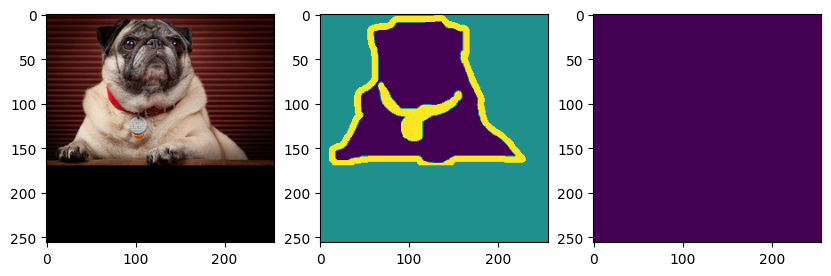

In [7]:
test_mask = np.ones_like(test_img[:,:,:,0])
for i in range(len(test_img)):
  test_mask[i,0:test_size[i,0],0:test_size[i,1]] = 1


_, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
ax[0].imshow(test_img[1])
ax[1].imshow(test_label[1].astype(int))
ax[2].imshow(test_mask[1]*255.)

In [8]:
class Finetune_set(Dataset):
  
  def __init__(self, img, label, mask, size):
    super().__init__()
    self.img = torch.Tensor(img).float().permute((0,3,1,2))/255.
    self.label = torch.Tensor(label).float() 
    self.mask = torch.Tensor(mask).float()
    self.size = torch.Tensor(size).float()

  def __len__(self):
    return len(self.img)

  def __getitem__(self,idx):
    return self.img[idx], self.label[idx], self.mask[idx], self.size[idx]

In [9]:

np.random.seed(42)

ids = list(range(test_img.shape[0]))
np.random.shuffle(ids)

# 40% labelled data, 60% unlabelled data
labelled_ids = ids[:int(0.4*test_img.shape[0])]
unlabelled_ids = ids[int(0.4*test_img.shape[0]):]

# 80% training, 5% validation, 15% test
train_ids = labelled_ids[:int(0.8*len(labelled_ids))]
valid_ids = labelled_ids[int(0.8*len(labelled_ids)):int(0.85*len(labelled_ids))]
test_ids = labelled_ids[int(0.85*len(labelled_ids)):]

# validation and test sets stay the same
valid_set = Finetune_set(test_img[valid_ids], test_label[valid_ids], test_mask[valid_ids], test_size[valid_ids])
test_set = Finetune_set(test_img[test_ids], test_label[test_ids], test_mask[test_ids], test_size[test_ids])
print(len(valid_set), len(test_set))

# training set for baseline and semi-supervised
base_train_set = Finetune_set(test_img[train_ids], test_label[train_ids], test_mask[train_ids], test_size[train_ids])
print(len(base_train_set))

# training set for upper bound
upper_train_set = Finetune_set(test_img[train_ids+unlabelled_ids], test_label[train_ids+unlabelled_ids], test_mask[train_ids+unlabelled_ids], test_size[train_ids+unlabelled_ids])
print(len(upper_train_set))

148 444
2364
6798


In [10]:
batch_size = 64

# validation and test sets stay the same
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, num_workers=2)

# need to choice which trainset to use
train_loader = DataLoader(base_train_set, shuffle=True, batch_size=batch_size, num_workers=2)

upper_train_loader = DataLoader(upper_train_set, shuffle=True, batch_size=batch_size, num_workers=2)

## load model

In [11]:
ckpt = torch.load('/content/drive/MyDrive/0197Group/Model/yingshuai_pretrain_AB.pth')

finetune= smp.Unet(
    encoder_name="resnet34",         # use ResNet34 as backbone
    encoder_weights=None,            # use randomly initialized weights
    encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
    decoder_use_batchnorm=True,      # if True, BatchNorm2d layer between Conv2D and Activation layers is used
    decoder_attention_type=None,     # attention module used in decoder (default=None)
    in_channels=4,                   # number of input channels, 1 additional attention mask (default=3, expects RGB images)
    activation=None,                 # activation function to apply after the final convolution layer (default=None)
    classes=3,                       # output 3 channels for trimaps
    aux_params=None,                 # parameters of the auxiliary output (defualt=None)
)


finetune.encoder.load_state_dict(ckpt['encoder'])
finetune.decoder.load_state_dict(ckpt['decoder'])
# finetune.segmentation_head.load_state_dict(ckpt['mask'])


finetune.to(device)
print("model loaded")

model loaded


In [12]:
def inference(image, label, mask, size, model, device):

    concated = torch.concat([image, mask.unsqueeze(0)], dim=0).to(device)

    input = image.to(device)
    model.eval()
    with torch.no_grad():
        output = model(concated.unsqueeze(0))
    
    trimap = torch.argmax(output.squeeze().detach().cpu().permute(1,2,0), dim=2)
    if size[1] == 256:
      trimap[int(size[0]):, :] = 1
    else:
      trimap[:, int(size[1]):] = 1
  
    _, ax = plt.subplots(nrows=1, ncols=3, figsize=(6,3))
    ax[0].imshow(image.permute(1,2,0).cpu())
    ax[1].imshow(label.cpu())
    ax[2].imshow(trimap)
    plt.show()

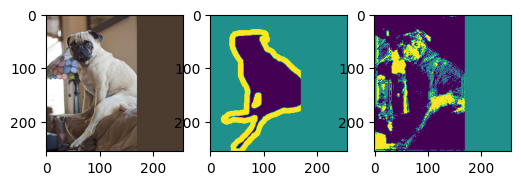

In [13]:
img, label, mask, size = next(iter(train_loader))
inference(img[0], label[0], mask[0], size[0], finetune, device)

## Finetune

In [14]:
lr = 3e-4
warm_up = 500
save_step = 50
training_step = 5000

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(finetune.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warm_up ,num_training_steps=training_step)

Averaged Train Loss: 0.91300205, Validation Loss: 0.86607785


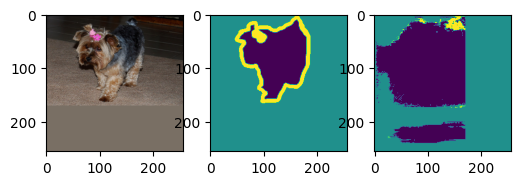

Model checkpoint saved at step 50
----------------------------------------
Averaged Train Loss: 0.71363665, Validation Loss: 0.40989025


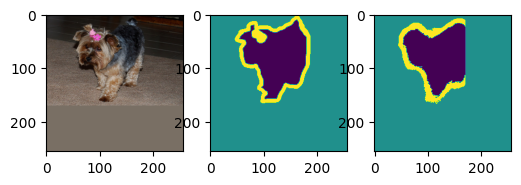

Model checkpoint saved at step 100
----------------------------------------
Averaged Train Loss: 0.58290903, Validation Loss: 0.27265353


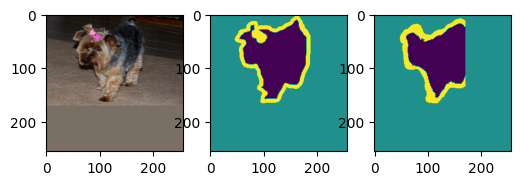

Model checkpoint saved at step 150
----------------------------------------
Averaged Train Loss: 0.49395455, Validation Loss: 0.21835530


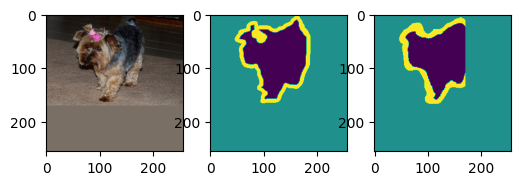

Model checkpoint saved at step 200
----------------------------------------
Averaged Train Loss: 0.43122281, Validation Loss: 0.19894493


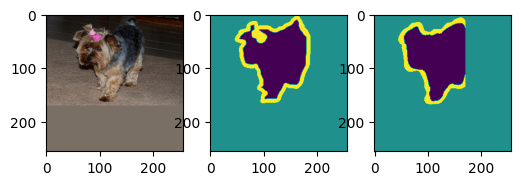

Model checkpoint saved at step 250
----------------------------------------
Averaged Train Loss: 0.38557053, Validation Loss: 0.18102779


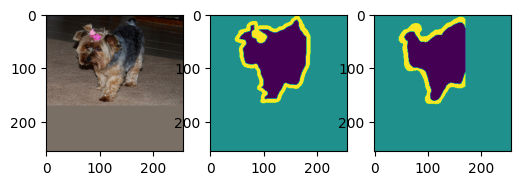

Model checkpoint saved at step 300
----------------------------------------
Averaged Train Loss: 0.35059001, Validation Loss: 0.16639351


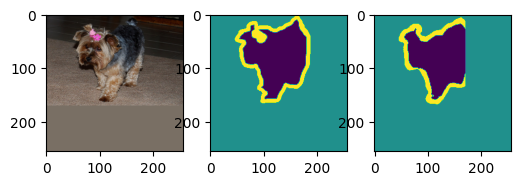

Model checkpoint saved at step 350
----------------------------------------
Averaged Train Loss: 0.32208940, Validation Loss: 0.16164484


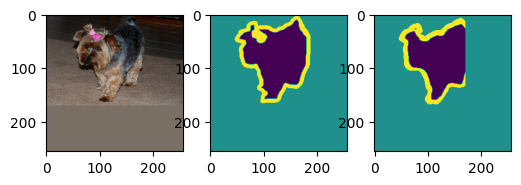

Model checkpoint saved at step 400
----------------------------------------
Averaged Train Loss: 0.29869907, Validation Loss: 0.16293413


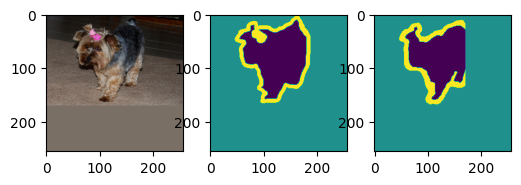

Model checkpoint saved at step 450
----------------------------------------
Over fitting warning
stop: 1
Averaged Train Loss: 0.27869265, Validation Loss: 0.14899316


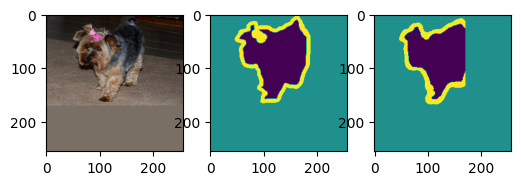

Model checkpoint saved at step 500
----------------------------------------
Averaged Train Loss: 0.26124652, Validation Loss: 0.15065584


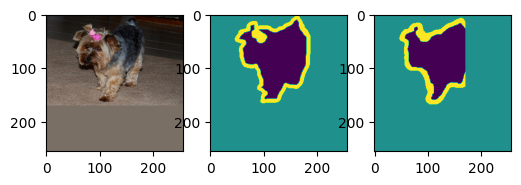

Model checkpoint saved at step 550
----------------------------------------
Over fitting warning
stop: 1
Averaged Train Loss: 0.24622701, Validation Loss: 0.15590049


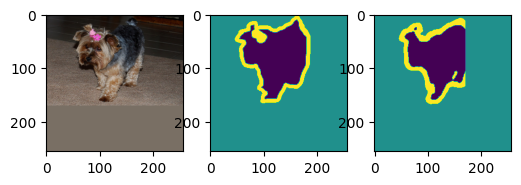

Model checkpoint saved at step 600
----------------------------------------
Over fitting warning
stop: 2
Averaged Train Loss: 0.23290534, Validation Loss: 0.15417939


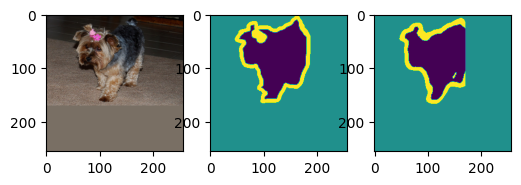

Model checkpoint saved at step 650
----------------------------------------
Averaged Train Loss: 0.22121545, Validation Loss: 0.16204718


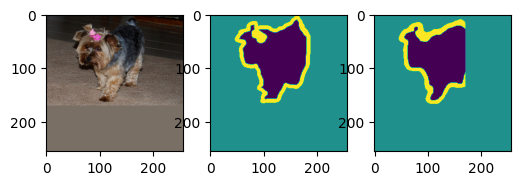

Model checkpoint saved at step 700
----------------------------------------
Over fitting warning
stop: 1
Averaged Train Loss: 0.21068722, Validation Loss: 0.16550673


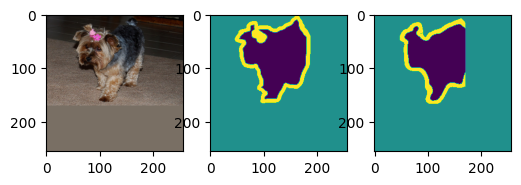

Model checkpoint saved at step 750
----------------------------------------
Over fitting warning
stop: 2
Averaged Train Loss: 0.20124201, Validation Loss: 0.17095485


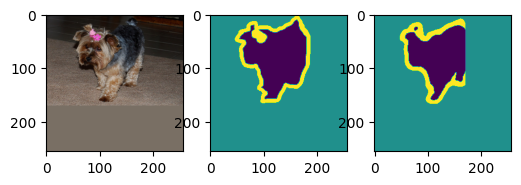

Model checkpoint saved at step 800
----------------------------------------
Over fitting warning
stop: 3
Model checkpoint saved at step 814
Early stopped at step:  814


In [15]:
model_name = 'jieming_semi_supervised'

loss_list = []
valid_loss_list = []
step = 0

stop = 0
best_loss = float('inf')
continue_training = True

while True:

    for X in train_loader:

        img, label, mask = X[0].to(device), X[1].long().to(device), X[2].to(device)
        concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 

        finetune.train()
        output = finetune(concated)
        loss = criterion(output*(mask.unsqueeze(1)), (label*mask).long())
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        step += 1

        if step % save_step == 0:
            
            finetune.eval()
            total_loss = 0.0
            for X in valid_loader:
                img, label, mask = X[0].to(device), X[1].long().to(device), X[2].to(device)
                concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 
                with torch.no_grad():
                    output = finetune(concated)
                loss = criterion(output*(mask.unsqueeze(1)), (label*mask).long())
                total_loss += loss.item() * img.shape[0]
            valid_loss = total_loss/len(valid_loader.dataset)
            valid_loss_list.append(valid_loss)
            print(f'Averaged Train Loss: {np.mean(loss_list):.8f}, Validation Loss: {valid_loss:.8f}')
            
            inference(img[1], label[1], mask[1], size[1], finetune, device)
            
            model_state_dict = {'encoder': finetune.encoder.state_dict(),
                                'decoder': finetune.decoder.state_dict(),
                                'mask': finetune.segmentation_head.state_dict(),
                                'optimizer': optimizer.state_dict(),
                                'scheduler': scheduler.state_dict()}
            torch.save(model_state_dict, f'/content/drive/MyDrive/0197Group/Model/{model_name}.pth')
            print(f'Model checkpoint saved at step {step}')
            print(40*'-')

            if len(valid_loss_list) > 3:
              if valid_loss >= valid_loss_list[-2]:
                stop += 1
                print("Over fitting warning")
                print(f"stop: {stop}")
              else:
                stop = 0

    if stop >= 3:
        model_state_dict = {'encoder': finetune.encoder.state_dict(),
                        'decoder': finetune.decoder.state_dict(),
                        'mask': finetune.segmentation_head.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict()}
        torch.save(model_state_dict, f'/content/drive/MyDrive/0197Group/Model/{model_name}.pth')
        print(f'Model checkpoint saved at step {step}')
        print('Early stopped at step: ', step)
        break
            
    if step == training_step:
        break

np.save(f'/content/drive/MyDrive/0197Group/Loss/{model_name}_train_loss.npy', np.array(loss_list))
np.save(f'/content/drive/MyDrive/0197Group/Loss/{model_name}_valid_loss.npy', np.array(valid_loss_list))

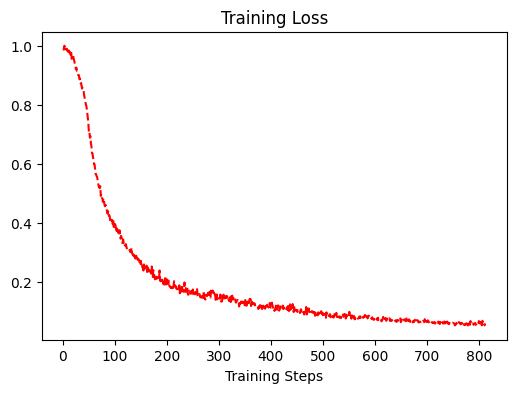

In [16]:
plt.figure(figsize=(6,4))
plt.plot(loss_list, 'r--')
plt.title('Training Loss')
plt.xlabel('Training Steps')
plt.show()

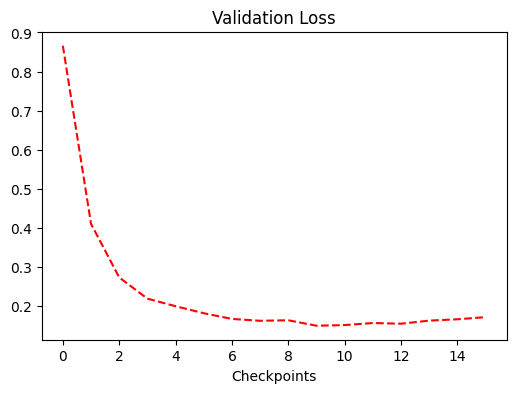

In [17]:
plt.figure(figsize=(6,4))
plt.plot(valid_loss_list, 'r--')
plt.title('Validation Loss')
plt.xlabel('Checkpoints')
plt.show()

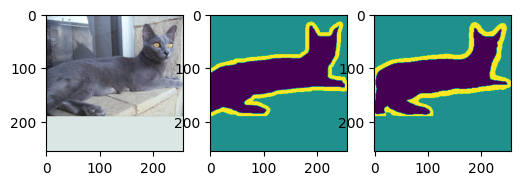

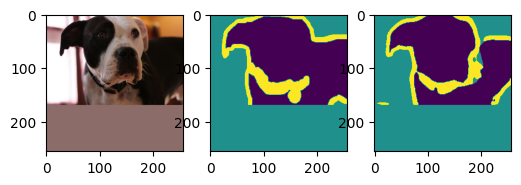

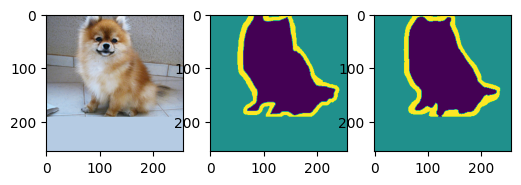

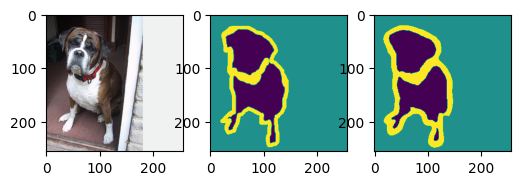

In [18]:
img, label, mask, size = next(iter(test_loader))
for i in range(4):
    inference(img[i], label[i], mask[i], size[i], finetune, device)

In [19]:
from sklearn.metrics import jaccard_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

def calculate_batch_metrics(y_true_batch, y_pred_batch):
    '''
    input: label_batch, output_batch
    output: iou, precision, recall, f1_score
    '''
    batch_size = y_true_batch.shape[0]
    batch_metrics = []

    for i in range(batch_size):
        y_true = y_true_batch[i].flatten()
        y_pred = y_pred_batch[i].flatten()

        iou = jaccard_score(y_true, y_pred, average="weighted")
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

        sample_metrics = [iou, precision, recall, f1_score]
        batch_metrics.append(sample_metrics)

    return np.array(batch_metrics)

metrics = [[0,0,0,0]]
for X in tqdm(test_loader):
  img, label_batch, mask, size_batch = X[0].to(device), X[1].long(), X[2].to(device), X[3]
  concated = torch.concat([img, mask.unsqueeze(1)], dim=1)
  output = finetune(concated)
  trimap_batch = torch.argmax(output.squeeze().detach().cpu().permute(0, 2, 3, 1), dim=3)
  for i in range(len(trimap_batch)):
    trimap = trimap_batch[i]
    size = size_batch[i]
    if size[1] == 256:
      trimap[int(size[0]):, :] = 1
    else:
      trimap[:, int(size[1]):] = 1

  batch_metrics = calculate_batch_metrics(label_batch, trimap_batch)
  metrics = np.concatenate((metrics, batch_metrics), axis = 0)
mask_metrics = np.mean(metrics[1:], axis = 0)
print("\n")
print(f"mean iou: {mask_metrics[0]:.4f}, precision: {mask_metrics[1]:.4f}, recall: {mask_metrics[2]:.4f}, f1-score: {mask_metrics[3]:.4f}")


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]



mean iou: 0.9007, precision: 0.9457, recall: 0.9424, f1-score: 0.9423
